In this notebook, one slice of the article's data is re-processed and we illustrate how one can mitigate inflated FA values by excluding voxels with high volume free water volume.

Let's first import the relevant modules:

In [1]:
import numpy as np
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
from dipy.data import fetch_cenir_multib
from dipy.data import read_cenir_multib
from dipy.segment.mask import median_otsu
from functions import nls_fit_tensor
import time
%matplotlib inline

Downloading data...

In [2]:
fetch_cenir_multib(with_raw=False)

bvals = [200, 400, 1000, 2000]

img, gtab = read_cenir_multib(bvals)

data = img.get_data()

affine = img.get_affine()

Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\Rafael\.dipy\cenir_multib 
Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\Rafael\.dipy\cenir_multib 


Estimate a brain mask...

In [3]:
maskdata, mask = median_otsu(data, 4, 2, False, vol_idx=[0, 1], dilate=1)

To speed up the processing time of this notebook, some lines of code are added so that only the plotted axial slice is processed.

In [4]:
axial_slice = 40
mask_roi = np.zeros(data.shape[:-1], dtype=bool)
mask_roi[:, :, axial_slice] = mask[:, :, axial_slice]

Fitting the free water DTI model...

In [5]:
t0 = time.time()
fw_params = nls_fit_tensor(gtab, data, mask_roi)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 76.803000 seconds to run


Compute tensor statistic from the fitted parameters...

In [6]:
evals = fw_params[..., :3]
FA = dti.fractional_anisotropy(evals)
MD = dti.mean_diffusivity(evals)
F = fw_params[..., 12]

Compute standard DTI for comparison...

In [7]:
dtimodel = dti.TensorModel(gtab)

dtifit = dtimodel.fit(data, mask=mask_roi)

dti_FA = dtifit.fa
dti_MD = dtifit.md

Plot data for a axial slice of the data ...

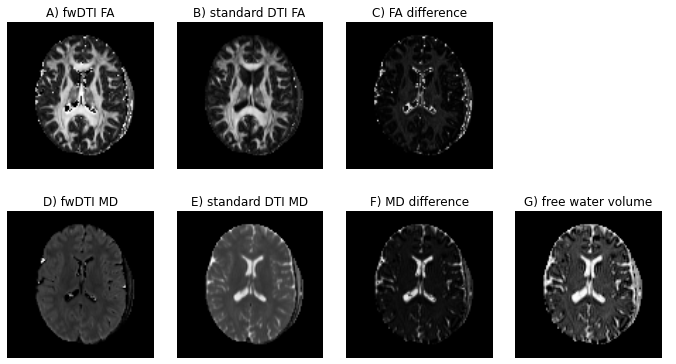

In [8]:
axial_slice = 40

fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('A) fwDTI FA')
ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[1].set_title('B) standard DTI FA')

FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
ax.flat[2].imshow(FAdiff.T, cmap='gray', origin='lower', vmin=0, vmax=1)
ax.flat[2].set_title('C) FA difference')

ax.flat[3].axis('off')

ax.flat[4].imshow(MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[4].set_title('D) fwDTI MD')
ax.flat[5].imshow(dti_MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[5].set_title('E) standard DTI MD')

MDdiff = abs(MD[:, :, axial_slice] - dti_MD[:, :, axial_slice])
ax.flat[6].imshow(MDdiff.T, origin='lower', cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[6].set_title('F) MD difference')

ax.flat[7].imshow(F[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[7].set_title('G) free water volume')

plt.show()
fig1.savefig('In_vivo_free_water_DTI_and_standard_DTI_measures.png')

As mentioned in the main article unexpected high amplitudes of FA are however observed in the periventricular gray mater. Above we mitigate this inflated values of FA by removing in our analysis all voxels with measured free water volume fraction of 0.7.

In [9]:
FA[F > 0.7] = 0
dti_FA[F > 0.7] = 0

Above we reproduce the plots of the in vivo FA from the two DTI fits and where we can see that the inflated FA values were practically removed:

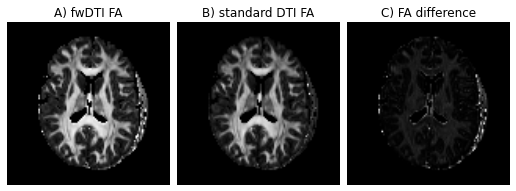

In [10]:
fig2, ax = plt.subplots(1, 3, figsize=(9, 3),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('A) fwDTI FA')
ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[1].set_title('B) standard DTI FA')

FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
ax.flat[2].imshow(FAdiff.T, cmap='gray', origin='lower', vmin=0, vmax=1)
ax.flat[2].set_title('C) FA difference')

plt.show()
fig2.savefig('In_vivo_free_water_DTI_and_standard_DTI_corrected.png')